# HUOPM: High-Utility Occupancy Pattern Mining
This notebook implements the HUOPM algorithm for discovering high-utility occupancy patterns in transactional databases.

In [1]:
from collections import defaultdict
import time
import random
from typing import Dict, List, Tuple, Set, Optional
import pandas as pd
import tracemalloc
from IPython.display import display
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

## UtilityOccupancyList Class
Represents the UO-list for tracking utility-occupancy stats per itemset.

In [2]:
class UtilityOccupancyList:
    """
    Represents a Utility-Occupancy List (UO-list) for a specific itemset.
    
    This structure stores transaction-level utility occupancy information and
    maintains aggregate statistics (support, average UO, average RUO) that
    form the Frequency-Utility (FU) table.

    Attributes:
        itemset (tuple): The itemset this UO-list represents (e.g., ('a', 'c'))
        entries (dict): Transaction entries {tid: {'uo': float, 'ruo': float}}
        sup (int): Support count (number of transactions containing this itemset)
        sum_uo (float): Sum of utility occupancy values across all transactions
        sum_ruo (float): Sum of remaining utility occupancy values
        uo (float): Average utility occupancy (sum_uo / sup)
        ruo (float): Average remaining utility occupancy (sum_ruo / sup)

    Example:
        >>> uo_list = UtilityOccupancyList(('a', 'c'))
        >>> uo_list.add_entry('T1', uo=0.5, ruo=0.2)
        >>> uo_list.add_entry('T2', uo=0.3, ruo=0.7)
        >>> uo_list.finalize_metrics()
        >>> print(uo_list.get_sup())    # Output: 2
        >>> print(uo_list.get_uo())     # Output: 0.4
        >>> print(uo_list.get_ruo())    # Output: 0.45
        >>> print(repr(uo_list))        # Output: UO-List(('a', 'c'), sup=2, uo=0.4000, ruo=0.4500)
    """

    def __init__(self, itemset: Tuple[str, ...]):
        """
        Initialize a UO-list for a given itemset.

        Args:
            itemset (tuple of str): The itemset for this UO-list, such as ('a', 'c')

        This initializes an empty set of transaction entries and zeros for all
        aggregate statistics.
        """
        self.itemset = tuple(itemset)
        self.entries: Dict[str, Dict[str, float]] = {}
        self.sup: int = 0
        self.sum_uo: float = 0.0
        self.sum_ruo: float = 0.0
        self.uo: float = 0.0
        self.ruo: float = 0.0

    def add_entry(self, tid: str, uo: float, ruo: float) -> None:
        """
        Add a transaction record to the UO-list.

        Args:
            tid (str): Unique transaction identifier.
            uo (float): Utility occupancy value for the itemset in this transaction.
            ruo (float): Remaining utility occupancy (from other items) in the transaction.

        If the transaction is not already present, this records the entry and updates
        the support count and running totals for UO and RUO values.

        Example:
            >>> uo_list.add_entry('T3', uo=0.8, ruo=0.1)
            >>> print(uo_list.sup)
            # Output: incremented support count
        """
        if tid not in self.entries:
            self.entries[tid] = {'uo': uo, 'ruo': ruo}
            self.sup += 1
            self.sum_uo += uo
            self.sum_ruo += ruo

    def finalize_metrics(self) -> None:
        """
        Calculate average utility occupancy and remaining utility occupancy for this itemset.

        This method should be called after all entries are added, before querying UO or RUO.

        Updates:
            - self.uo: Average utility occupancy (sum_uo / sup)
            - self.ruo: Average remaining utility occupancy (sum_ruo / sup)

        Example:
            >>> uo_list.finalize_metrics()
            >>> print(uo_list.uo)   # Output: average UO
            >>> print(uo_list.ruo)  # Output: average RUO
        """
        if self.sup > 0:
            self.uo = self.sum_uo / self.sup
            self.ruo = self.sum_ruo / self.sup
        else:
            self.uo = 0.0
            self.ruo = 0.0

    def get_sup(self) -> int:
        """
        Return the support count for the itemset.

        Returns:
            int: Number of transactions containing this itemset.

        Example:
            >>> support = uo_list.get_sup()
            >>> print(support)
            # Output: support count as integer
        """
        return self.sup
        
    def get_uo(self) -> float:
        """
        Return the computed average utility occupancy for the itemset.

        Returns:
            float: The average utility occupancy (UO) value.

        Example:
            >>> avg_uo = uo_list.get_uo()
            >>> print(avg_uo)
            # Output: average UO as float
        """
        return self.uo
    
    def get_ruo(self) -> float:
        """
        Return the computed average remaining utility occupancy for the itemset.

        Returns:
            float: The average remaining utility occupancy (RUO) value.

        Example:
            >>> avg_ruo = uo_list.get_ruo()
            >>> print(avg_ruo)
            # Output: average RUO as float
        """
        return self.ruo

    def __repr__(self) -> str:
        """
        Return a readable string summary of the UO-list object.

        Displays:
            - The itemset tuple
            - Support count
            - Average UO (to 4 decimals)
            - Average RUO (to 4 decimals)

        Example:
            >>> print(repr(uo_list))
            # Output: UO-List(('a', 'c'), sup=2, uo=0.4000, ruo=0.4500)
        """
        return f"UO-List({self.itemset}, sup={self.sup}, uo={self.uo:.4f}, ruo={self.ruo:.4f})"


## HUOPM Mining Class
Implements the main HUOPM mining algorithm.

In [3]:
class HUOPM:
    """
    High-Utility Occupancy Pattern Mining (HUOPM) Algorithm.

    This class implements the HUOPM algorithm, which discovers patterns that satisfy both 
    minimum support (frequency) and minimum utility occupancy (average utility ratio) thresholds.

    Attributes:
        min_sup_ratio (float): Minimum support threshold (alpha), range [0, 1]
        min_uo_ratio (float): Minimum utility occupancy threshold (beta), range [0, 1]
        min_sup_count (int): Minimum support count (auto-calculated after data loaded)
        transactions_dict (dict): Transaction data {tid: [(item, qty), ...]}
        profit_table (dict): Profit/unit-utility per item {item: profit}
        tu_table (dict): Transaction utility table {tid: TU}
        total_order (list): List of items ordered by minimum support
        item_to_order_index (dict): Index map for each item in total_order
        huops (list): Final output, list of (itemset, support, uo) patterns

    Example:
        >>> miner = HUOPM(0.02, 0.3)
        >>> results = miner.fit(transactions_dict, profit_table)
        >>> print(results)
        [(('a', 'c'), 10, 0.42), ...]
    """
    
    def __init__(self, min_sup_ratio: float, min_uo_ratio: float):
        """
        Initialize an HUOPM miner with given frequency and utility occupancy thresholds.

        Args:
            min_sup_ratio (float): Minimum support ratio (alpha), value in [0, 1].
            min_uo_ratio (float): Minimum utility occupancy ratio (beta), value in [0, 1].

        Raises:
            ValueError: If either threshold is not within allowed range [0, 1].

        Example:
            >>> miner = HUOPM(0.01, 0.25)
        """
        if not (0 <= min_sup_ratio <= 1):
            raise ValueError(f"min_sup_ratio must be in [0, 1], got {min_sup_ratio}")
        if not (0 <= min_uo_ratio <= 1):
            raise ValueError(f"min_uo_ratio must be in [0, 1], got {min_uo_ratio}")
            
        self.min_sup_ratio = min_sup_ratio
        self.min_uo_ratio = min_uo_ratio
        
        # Mining state variables
        self.min_sup_count: int = 0
        self.transactions_dict: Dict[str, List[Tuple[str, int]]] = {}
        self.profit_table: Dict[str, float] = {}
        self.tu_table: Dict[str, float] = {}
        self.total_order: List[str] = []
        self.item_to_order_index: Dict[str, int] = {}
        self.huops: List[Tuple[Tuple[str, ...], int, float]] = []

    def fit(self, transactions_dict: Dict[str, List[Tuple[str, int]]], profit_table: Dict[str, float]) -> List[Tuple[Tuple[str, ...], int, float]]:
        """
        Execute the HUOPM algorithm on transactional data.

        Args:
            transactions_dict (dict): Transaction DB {tid: [(item, qty), ...]}.
            profit_table (dict): Profit/unit-utility for each item {item: profit}.

        Returns:
            List[Tuple[Tuple[str, ...], int, float]]: List of patterns (itemset, support, uo).

        Raises:
            ValueError: If input dictionaries are empty.

        Example:
            >>> miner = HUOPM(0.01, 0.2)
            >>> miner.fit(tx_db, profits)
        """
        if not transactions_dict:
            raise ValueError("transactions_dict cannot be empty")
        if not profit_table:
            raise ValueError("profit_table cannot be empty")
        
        print("Starting HUOPM Algorithm...")
        start_time = time.time()
        
        self.transactions_dict = transactions_dict
        self.profit_table = profit_table
        self.min_sup_count = int(self.min_sup_ratio * len(transactions_dict))
        
        if self.min_sup_count < 1:
            self.min_sup_count = 1
        
        print(f"  Total transactions: {len(transactions_dict)}")
        print(f"  min_sup_count: {self.min_sup_count} (alpha: {self.min_sup_ratio})")
        print(f"  min_uo_ratio (beta): {self.min_uo_ratio}")

        # PASS 1: Calculate TU, item supports, total order ===
        print("Phase 1: Scanning database for support and TU...")
        pass1_start = time.time()
        I_star, self.total_order = self._scan1()
        self.item_to_order_index = {item: i for i, item in enumerate(self.total_order)}
        print(f"  Frequent 1-itemsets (I*): {len(I_star)}")

        # PASS 2: Build UO-lists for 1-itemsets ===
        print("Phase 2: Building initial UO-lists...")
        pass2_start = time.time()
        initial_extensions = self._scan2(I_star)
        print(f"  Initial UO-lists built: {len(initial_extensions)}")

        # RECURSIVE SEARCH: Find all HUOPs ===
        print("Phase 3: Starting recursive HUOP mining...")
        search_start = time.time()
        self._huop_search(None, initial_extensions)
        
        total_time = time.time() - start_time
        print(f"Mining completed in {total_time:.4f}s")
        print(f"Total HUOPs discovered: {len(self.huops)}")
        
        return self.huops

    def _scan1(self) -> Tuple[Set[str], List[str]]:
        """
        Pass1: First database scan: Calculate transaction utilities and establish total order.

        Returns:
            Tuple[Set[str], List[str]]: A tuple containing:
                - I_star (set of str): Set of frequent items (items with support >= min_sup_count)
                - total_order (list of str): Sorted list of frequent items ordered by 
                (support_count, item_name) for deterministic processing

        Example:
            >>> I_star, total_order = miner._scan1()
            >>> print(f"Frequent items: {I_star}")
            >>> print(f"Total order: {total_order}")
            {'a', 'b', 'c', 'd'}
            ['a', 'c', 'b', 'd']
        """
        item_sup = defaultdict(int)
        
        # Reset TU table to ensure no stale data
        self.tu_table = {} 

        for tid, transaction in self.transactions_dict.items():
            current_tu = 0.0
            seen_items = set()
            for item, qty in transaction:
                if item in self.profit_table:
                    # Force float calculation for consistency
                    profit = float(self.profit_table[item])
                    current_tu += float(qty) * profit
                    seen_items.add(item)
            
            self.tu_table[tid] = current_tu
            for item in seen_items:
                item_sup[item] += 1
        
        I_star = {item for item, sup in item_sup.items() if sup >= self.min_sup_count}
        
        self.total_order = sorted(list(I_star), key=lambda i: (item_sup[i], i))
        
        return I_star, self.total_order

    def _scan2(self, I_star: Set[str]) -> List["UtilityOccupancyList"]:
        """
        Pass 2: Build UO-lists for 1-itemsets using support, ordered items, and transaction utilities.

        Args:
            I_star (set of str): Set of frequent 1-itemsets.

        Returns:
            List[UtilityOccupancyList]: Initial list of UtilityOccupancyList objects, one per frequent item.

        Example:
            >>> initial_uols = miner._scan2(I_star)
        """
        uo_lists = {item: UtilityOccupancyList((item,)) for item in I_star}
        
        for tid, transaction in self.transactions_dict.items():
            tu = self.tu_table.get(tid, 0.0)
            
            if tu == 0:
                continue
            
            frequent_items_in_tx = []
            item_utilities = {}
            
            for item, qty in transaction:
                if item in I_star and item in self.profit_table:
                    profit = self.profit_table[item]
                    utility = qty * profit
                    if utility > 0:
                        frequent_items_in_tx.append(item)
                        item_utilities[item] = utility
            
            sorted_items = sorted(
                frequent_items_in_tx,
                key=lambda i: self.item_to_order_index.get(i, float('inf'))
            )
            
            for i, item in enumerate(sorted_items):
                item_uo = item_utilities[item] / tu
                item_ruo = 0.0
                for j in range(i + 1, len(sorted_items)):
                    item_ruo += item_utilities[sorted_items[j]] / tu
                
                uo_lists[item].add_entry(tid, item_uo, item_ruo)
        
        final_extensions = []
        for item in self.total_order:
            if item in uo_lists:
                uol = uo_lists[item]
                uol.finalize_metrics()
                final_extensions.append(uol)
        
        return final_extensions

    def _huop_search(self, prefix_UOL: Optional["UtilityOccupancyList"], extensions_list: List["UtilityOccupancyList"]) -> None:
        """
        Perform depth-first recursive search for high-utility occupancy patterns.
        
        Applies:
            - Frequency pruning
            - Pattern acceptance
            - Upper-bound pruning (ϕ̂)

        Args:
            prefix_UOL (UtilityOccupancyList | None): Current UO-list used as prefix, or None for root.
            extensions_list (list of UtilityOccupancyList): List of extensions to explore.

        Returns:
            None

        Example:
            >>> miner._huop_search(None, initial_uols)
        """
        for i in range(len(extensions_list)):
            Xa_UOL = extensions_list[i]
            
            # Strategy 1: Frequency pruning
            if Xa_UOL.get_sup() < self.min_sup_count:
                continue
            
            if Xa_UOL.get_uo() >= self.min_uo_ratio:
                self.huops.append((
                    Xa_UOL.itemset,
                    Xa_UOL.get_sup(),
                    Xa_UOL.get_uo()
                ))
            
            # Strategy 2: Upper-bound pruning
            phi_hat_Xa = self._calculate_upper_bound(Xa_UOL)
            
            if phi_hat_Xa >= self.min_uo_ratio:
                extenOfXa = []
                
                for j in range(i + 1, len(extensions_list)):
                    Xb_UOL = extensions_list[j]
                    
                    Xab_UOL = self._construct(prefix_UOL, Xa_UOL, Xb_UOL)
                    
                    # Strategy 3 & 4: Only keep if frequent
                    if Xab_UOL.get_sup() >= self.min_sup_count:
                        extenOfXa.append(Xab_UOL)
                
                if extenOfXa:
                    self._huop_search(Xa_UOL, extenOfXa)

    def _construct(self, X_UOL: Optional["UtilityOccupancyList"], Xa_UOL: "UtilityOccupancyList", Xb_UOL: "UtilityOccupancyList") -> "UtilityOccupancyList":
        """
        Construct a UO-list for the join of itemsets (Xa, Xb), adapting the construction algorithm for k=2 and k>2 cases.

        Args:
            X_UOL (UtilityOccupancyList | None): UO-list of the prefix (for k>2), or None for k=2.
            Xa_UOL (UtilityOccupancyList): UO-list for left itemset.
            Xb_UOL (UtilityOccupancyList): UO-list for right itemset.

        Returns:
            UtilityOccupancyList: The constructed UO-list for the joined itemset.

        Example:
            >>> Xab_UOL = miner._construct(X_UOL, Xa_UOL, Xb_UOL)
        """
        Xab_itemset = Xa_UOL.itemset + (Xb_UOL.itemset[-1],)
        Xab_UOL = UtilityOccupancyList(Xab_itemset)
        
        common_tids = Xa_UOL.entries.keys() & Xb_UOL.entries.keys()
        
        Xa_entries = Xa_UOL.entries
        Xb_entries = Xb_UOL.entries
        X_entries = X_UOL.entries if X_UOL else None
        
        for tid in common_tids:
            Ea = Xa_entries[tid]
            Eb = Xb_entries[tid]
            
            new_ruo = Eb['ruo']
            new_uo = 0.0
            
            if X_entries is None:
                # Case k=2
                new_uo = Ea['uo'] + Eb['uo']
            else:
                # Case k>2
                E = X_entries.get(tid)
                if E:
                    new_uo = Ea['uo'] + Eb['uo'] - E['uo']
                else:
                    new_uo = Ea['uo'] + Eb['uo']
            
            Xab_UOL.add_entry(tid, new_uo, new_ruo)
        
        Xab_UOL.finalize_metrics()
        return Xab_UOL

    def _calculate_upper_bound(self, uol: "UtilityOccupancyList") -> float:
        """
        Compute the utility occupancy upper bound (ϕ̂) for a given UO-list.

        Args:
            uol (UtilityOccupancyList): The list for which the bound is calculated.

        Returns:
            float: The upper bound ϕ̂, used to prune the search space.

        Example:
            >>> phi_hat = miner._calculate_upper_bound(uol)
        """
        V_occu = []
        for entry in uol.entries.values():
            potential_uo = entry['uo'] + entry['ruo']
            V_occu.append(potential_uo)
        
        V_occu.sort(reverse=True)
        
        k = self.min_sup_count
        
        if len(V_occu) < k:
            return 0.0
        
        sum_top_k = sum(V_occu[:k])
        
        return sum_top_k / k if k > 0 else 0.0

## Helper Functions
Functions for data loading, profit table generation

In [4]:
def parse_dataset(filepath: str) -> Tuple[List[List[str]], Set[str]]:
    """
    Parse space-delimited transactional dataset file into item-only transactions.
    
    PURPOSE:
    Read standard sparse transaction format (one transaction per line, 
    space-separated item IDs) used by most utility mining algorithms.
    
    INPUT FORMAT:
    ```
    A B C
    B D
    A C
    ```
    
    OUTPUT FORMAT:
    ```
    transactions: [['A','B','C'], ['B','D'], ['A','C']]
    all_items: {'A','B','C','D'}
    ```
    
    ERROR HANDLING:
    - FileNotFoundError → empty lists/sets with error message
    - Malformed lines (empty after strip) → skipped silently
    - Other IO errors → empty lists/sets with error message
    
    PARAMETERS:
    filepath : str
        Path to dataset file
        
    RETURNS:
    Tuple[List[List[str]], Set[str]]:
        - transactions: List of transaction lists (items as strings)
        - all_items: Set of all unique items across dataset
    """
    """Parse a space-delimited transactional dataset file."""
    transactions = []
    all_items = set()
    
    print(f"Parsing dataset: {filepath}")
    
    try:
        with open(filepath, 'r') as f:
            for line_num, line in enumerate(f, 1):
                items = line.strip().split()
                if items:
                    transactions.append(items)
                    all_items.update(items)
        
        print(f"  Parsed {len(transactions)} transactions, {len(all_items)} unique items.")
        
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return [], set()
    except Exception as e:
        print(f"Error reading file: {e}")
        return [], set()
    
    return transactions, all_items



def generate_profit_table(all_items: Set[str], 
                          min_profit: float = 0.1,
                          max_profit: float = 10.0) -> Dict[str, float]:
    """
    Generate synthetic external utility (profit) table for utility mining.
    
    PURPOSE:
    Assign random profit-per-unit values to items for experimentation.
    Simulates real-world scenario where items have different profit margins.
    
    DISTRIBUTION:
    Uniform random [min_profit, max_profit], rounded to 2 decimal places.
    
    EXAMPLE:
    Input: {'A','B','C'}
    Output: {'A': 3.45, 'B': 7.82, 'C': 1.23}
    
    PARAMETERS:
    all_items : Set[str]
        All unique items requiring profit values
    min_profit : float = 0.1
        Minimum profit per unit
    max_profit : float = 10.0  
        Maximum profit per unit
        
    RETURNS:
    Dict[str, float]: {item → profit_per_unit}
    """
    """Generate a dictionary assigning random profit values to each item."""
    print(f"Generating profit table for {len(all_items)} items...")
    
    profit_table = {}
    sorted_items = sorted(list(all_items))
    for item in sorted_items:
        profit_table[item] = round(random.uniform(min_profit, max_profit), 2)
    
    return profit_table



def simulate_quantitative_data(
    base_transactions: List[List[str]],
    min_quantity: int = 1,
    max_quantity: int = 5
) -> Tuple[Dict[str, List[Tuple[str, int]]], Dict[str, float]]:
    """
    Convert sparse transactions to quantitative format for HUOPM.
    
    PURPOSE:
    Transform item-only transactions into HUOPM-compatible format by:
    1. Assigning TID strings (T1, T2, ...)
    2. Adding random quantities per item [min_quantity, max_quantity]
    3. Generating matching profit table
    
    INPUT FORMAT:
    [['A','B'], ['B','C','D']]
    
    OUTPUT FORMAT:
    transactions_dict: {
        'T1': [('A', 3), ('B', 1)], 
        'T2': [('B', 4), ('C', 2), ('D', 5)]
    }
    profit_table: {'A': 5.2, 'B': 3.1, ...}
    
    PARAMETERS:
    base_transactions : List[List[str]]
        Sparse transactions (items only)
    min_quantity : int = 1
        Minimum quantity per item occurrence
    max_quantity : int = 5
        Maximum quantity per item occurrence
        
    RETURNS:
    Tuple[Dict[str, List[Tuple[str,int]]], Dict[str,float]]:
        - transactions_dict: {TID → [(item, quantity), ...]}
        - profit_table: {item → profit_per_unit}
    """
    """Simulate quantitative transaction data by assigning random quantities to items."""
    all_items = set()
    for tx in base_transactions:
        all_items.update(tx)
    
    profit_table = generate_profit_table(all_items)
    
    print(f"Simulating quantitative data for {len(base_transactions)} transactions...")
    
    transactions_dict = {}
    for i, tx in enumerate(base_transactions):
        tid = f"T{i+1}"
        quantitative_tx = []
        
        for item in tx:
            quantity = random.randint(min_quantity, max_quantity)
            quantitative_tx.append((item, quantity))
        
        transactions_dict[tid] = quantitative_tx
    
    return transactions_dict, profit_table


print("Dataset parsing functions loaded!")

Dataset parsing functions loaded!


## Experiment: Running HUOPM Miner
Below, data is loaded, parameters set, mining is executed, and results are saved.

In [5]:
random.seed(42) #Use the same number (e.g., 42) in testing files

BASE_OUTPUT_DIR = "huopm_results"
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

def run_dataset_experiment(dataset_name, filepath, alpha_tests, beta_tests):
    """
    Runs experiments specifically for the HUOPM class defined in this notebook.
    
    Args:
        dataset_name (str): Name of the dataset (e.g., "Retail")
        filepath (str): Path to the .txt file
        alpha_tests (list): List of support thresholds
        beta_tests (list): List of utility occupancy thresholds
    """
    # CONFIGURATION
    algo_label = "HUOPM_Original" 
    AlgorithmClass = HUOPM

    print(f"START RUNNING: {dataset_name} using {algo_label}")
    
    #Create Sub-directory: huopm_results/Retail/HUOPM_Original/
    dataset_dir = os.path.join(BASE_OUTPUT_DIR, dataset_name, algo_label)
    os.makedirs(dataset_dir, exist_ok=True)
    print(f"Output Directory: {dataset_dir}")

    # 2. Parse & Simulate Data
    try:
        print(f"Loading data from: {filepath}")
        random.seed(42)
        base_transactions, all_items = parse_dataset(filepath)
        
        if not base_transactions:
            print(" No transactions found. Check filepath.")
            return

        print(f"   Parsed {len(base_transactions)} transactions.")
        
        print("   Generating synthetic utility values...")
        transactions_dict, profit_table = simulate_quantitative_data(base_transactions)
        
    except Exception as e:
        print(f" CRITICAL ERROR loading {dataset_name}: {e}")
        return

    summary_list = []

    # 3. Main Loop
    for alpha in alpha_tests:
        for beta in beta_tests:
            print(f"\nRunning: Alpha={alpha}, Beta={beta} ...")
            
            # Initialize the specific HUOPM class
            miner = AlgorithmClass(min_sup_ratio=alpha, min_uo_ratio=beta)
            
            tracemalloc.start()
            start_time = time.time()
            
            try:
                # EXECUTE
                huops_results = miner.fit(transactions_dict, profit_table)
                
                # METRICS
                end_time = time.time()
                current_mem, peak_mem = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                
                runtime = end_time - start_time
                peak_memory_mb = peak_mem / (1024 * 1024)
                num_patterns = len(huops_results)
                
                print(f" DONE in {runtime:.4f}s | Mem: {peak_memory_mb:.2f}MB | Patterns: {num_patterns}")

                # 4. Save Pattern File
                pattern_filename = f"{dataset_name}_{algo_label}_a{alpha}_b{beta}.txt"
                pattern_path = os.path.join(dataset_dir, pattern_filename)
                
                with open(pattern_path, "w", encoding='utf-8') as f:
                    # Write Header exactly as requested
                    f.write(f"# Dataset: {dataset_name}\n")
                    f.write(f"# Algorithm: {algo_label}\n")  # Algorithm Name
                    f.write(f"# Params: Alpha={alpha}, Beta={beta}\n")
                    f.write(f"# Runtime: {runtime:.6f}s\n")
                    f.write(f"# Peak Memory: {peak_memory_mb:.6f} MB\n")
                    f.write(f"# Count: {num_patterns}\n")
                    
                    # Write Patterns
                    for pat in huops_results:
                        f.write(f"{pat}\n") 
                
                # Add to summary list
                summary_list.append({
                    'dataset': dataset_name,
                    'algorithm': algo_label,
                    'alpha': alpha,
                    'beta': beta,
                    'runtime_sec': runtime,
                    'peak_memory_mb': peak_memory_mb,
                    'patterns_found': num_patterns,
                    'pattern_file_path': pattern_path
                })

            except Exception as e:
                print(f"ERROR during mining: {e}")
                tracemalloc.stop()

    # 5. Save Dataset Summary CSV
    if summary_list:
        df_final = pd.DataFrame(summary_list)
        csv_path = os.path.join(dataset_dir, f"{dataset_name}_{algo_label}_summary.csv")
        df_final.to_csv(csv_path, index=False)
        print(f"\nExperiment Finished. Summary saved to: {csv_path}")
        display(df_final)
    else:
        print(f"\nExperiment Finished. No results to save.")

In [6]:
# Small test with toy data
print("SMALL TEST: Verifying HUOPM implementation")

toy_transactions = {
    'T1': [('A', 2), ('B', 6), ('C', 1)],
    'T2': [('A', 1), ('D', 3), ('G', 2)],
    'T3': [('B', 1), ('D', 2), ('G', 3)],
    'T4': [('A', 1), ('C', 5), ('D', 2)],
    'T5': [('B', 4), ('D', 1), ('F', 1)],
}

toy_profits = {
    'A': 3.0, 'B': 1.0, 'C': 1.0,
    'D': 5.0, 'F': 3.0, 'G': 2.0,
}

miner = HUOPM(min_sup_ratio=0.4, min_uo_ratio=0.3)
results = miner.fit(toy_transactions, toy_profits)

print("\nResults:")
for pattern, support, uo in results[:10]:
    print(f"  {pattern}: sup={support}, uo={uo:.4f}")

print("\nSmall test completed successfully!")

SMALL TEST: Verifying HUOPM implementation
Starting HUOPM Algorithm...
  Total transactions: 5
  min_sup_count: 2 (alpha: 0.4)
  min_uo_ratio (beta): 0.3
Phase 1: Scanning database for support and TU...
  Frequent 1-itemsets (I*): 5
Phase 2: Building initial UO-lists...
  Initial UO-lists built: 5
Phase 3: Starting recursive HUOP mining...
Mining completed in 0.0001s
Total HUOPs discovered: 5

Results:
  ('C', 'A'): sup=2, uo=0.4915
  ('G', 'D'): sup=2, uo=0.9024
  ('A', 'D'): sup=2, uo=0.7702
  ('B', 'D'): sup=2, uo=0.6985
  ('D',): sup=4, uo=0.5606

Small test completed successfully!


### --- RETAIL EXPERIMENT ---

In [7]:
dataset_name = "Retail"
filepath = "datasets/retail.txt" 

alphas = [0.002,0.001,0.0008]
betas = [0.2,0.3]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Retail using HUOPM_Original
Output Directory: huopm_results/Retail/HUOPM_Original
Loading data from: datasets/retail.txt
Parsing dataset: datasets/retail.txt
  Parsed 88162 transactions, 16470 unique items.
   Parsed 88162 transactions.
   Generating synthetic utility values...
Generating profit table for 16470 items...
Simulating quantitative data for 88162 transactions...

Running: Alpha=0.002, Beta=0.2 ...
Starting HUOPM Algorithm...
  Total transactions: 88162
  min_sup_count: 176 (alpha: 0.002)
  min_uo_ratio (beta): 0.2
Phase 1: Scanning database for support and TU...
  Frequent 1-itemsets (I*): 963
Phase 2: Building initial UO-lists...
  Initial UO-lists built: 963
Phase 3: Starting recursive HUOP mining...
Mining completed in 17.2668s
Total HUOPs discovered: 299
 DONE in 18.0545s | Mem: 145.06MB | Patterns: 299

Running: Alpha=0.002, Beta=0.3 ...
Starting HUOPM Algorithm...
  Total transactions: 88162
  min_sup_count: 176 (alpha: 0.002)
  min_uo_ratio (beta): 0.3

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Retail,HUOPM_Original,0.0020,0.2,18.054504,145.056873,299,huopm_results/Retail/HUOPM_Original/Retail_HUO...
1,Retail,HUOPM_Original,0.0020,0.3,18.083565,144.914639,43,huopm_results/Retail/HUOPM_Original/Retail_HUO...
2,Retail,HUOPM_Original,0.0010,0.2,40.900689,180.906200,751,huopm_results/Retail/HUOPM_Original/Retail_HUO...
3,Retail,HUOPM_Original,0.0010,0.3,42.583706,180.762063,111,huopm_results/Retail/HUOPM_Original/Retail_HUO...
4,Retail,HUOPM_Original,0.0008,0.2,166.480533,191.417149,1031,huopm_results/Retail/HUOPM_Original/Retail_HUO...
5,Retail,HUOPM_Original,0.0008,0.3,62.454016,191.371502,143,huopm_results/Retail/HUOPM_Original/Retail_HUO...


### --- FOODMART EXPERIMENT ---


In [8]:
dataset_name = "Foodmart"
filepath = "datasets/foodmartFIM.txt" 

alphas = [0.005,0.001,0.0005]
betas = [0.2, 0.3]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Foodmart using HUOPM_Original
Output Directory: huopm_results/Foodmart/HUOPM_Original
Loading data from: datasets/foodmartFIM.txt
Parsing dataset: datasets/foodmartFIM.txt
  Parsed 4141 transactions, 1559 unique items.
   Parsed 4141 transactions.
   Generating synthetic utility values...
Generating profit table for 1559 items...
Simulating quantitative data for 4141 transactions...

Running: Alpha=0.005, Beta=0.2 ...
Starting HUOPM Algorithm...
  Total transactions: 4141
  min_sup_count: 20 (alpha: 0.005)
  min_uo_ratio (beta): 0.2
Phase 1: Scanning database for support and TU...
  Frequent 1-itemsets (I*): 20
Phase 2: Building initial UO-lists...
  Initial UO-lists built: 20
Phase 3: Starting recursive HUOP mining...
Mining completed in 0.0544s
Total HUOPs discovered: 12
 DONE in 0.0547s | Mem: 0.29MB | Patterns: 12

Running: Alpha=0.005, Beta=0.3 ...
Starting HUOPM Algorithm...
  Total transactions: 4141
  min_sup_count: 20 (alpha: 0.005)
  min_uo_ratio (beta): 0.3
Ph

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Foodmart,HUOPM_Original,0.0050,0.2,0.054703,0.289967,12,huopm_results/Foodmart/HUOPM_Original/Foodmart...
1,Foodmart,HUOPM_Original,0.0050,0.3,0.053899,0.289056,9,huopm_results/Foodmart/HUOPM_Original/Foodmart...
2,Foodmart,HUOPM_Original,0.0010,0.2,6.285495,5.430154,933,huopm_results/Foodmart/HUOPM_Original/Foodmart...
3,Foodmart,HUOPM_Original,0.0010,0.3,6.386619,5.371320,399,huopm_results/Foodmart/HUOPM_Original/Foodmart...
4,Foodmart,HUOPM_Original,0.0005,0.2,6.177275,5.561203,3302,huopm_results/Foodmart/HUOPM_Original/Foodmart...
5,Foodmart,HUOPM_Original,0.0005,0.3,6.741385,5.622536,2280,huopm_results/Foodmart/HUOPM_Original/Foodmart...


### --- MUSHROOM EXPERIMENT ---


In [9]:
dataset_name = "Mushroom"
filepath = "datasets/mushrooms.txt"

alphas = [0.4, 0.3, 0.2]  
betas = [0.4, 0.5]        

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Mushroom using HUOPM_Original
Output Directory: huopm_results/Mushroom/HUOPM_Original
Loading data from: datasets/mushrooms.txt
Parsing dataset: datasets/mushrooms.txt
  Parsed 8416 transactions, 119 unique items.
   Parsed 8416 transactions.
   Generating synthetic utility values...
Generating profit table for 119 items...
Simulating quantitative data for 8416 transactions...

Running: Alpha=0.4, Beta=0.4 ...
Starting HUOPM Algorithm...
  Total transactions: 8416
  min_sup_count: 3366 (alpha: 0.4)
  min_uo_ratio (beta): 0.4
Phase 1: Scanning database for support and TU...
  Frequent 1-itemsets (I*): 21
Phase 2: Building initial UO-lists...
  Initial UO-lists built: 21
Phase 3: Starting recursive HUOP mining...
Mining completed in 3.4915s
Total HUOPs discovered: 0
 DONE in 3.6008s | Mem: 35.49MB | Patterns: 0

Running: Alpha=0.4, Beta=0.5 ...
Starting HUOPM Algorithm...
  Total transactions: 8416
  min_sup_count: 3366 (alpha: 0.4)
  min_uo_ratio (beta): 0.5
Phase 1: Scan

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Mushroom,HUOPM_Original,0.4,0.4,3.600825,35.490477,0,huopm_results/Mushroom/HUOPM_Original/Mushroom...
1,Mushroom,HUOPM_Original,0.4,0.5,2.756991,33.241212,0,huopm_results/Mushroom/HUOPM_Original/Mushroom...
2,Mushroom,HUOPM_Original,0.3,0.4,6.842679,57.847949,2,huopm_results/Mushroom/HUOPM_Original/Mushroom...
3,Mushroom,HUOPM_Original,0.3,0.5,4.303945,48.017570,0,huopm_results/Mushroom/HUOPM_Original/Mushroom...
4,Mushroom,HUOPM_Original,0.2,0.4,3733.685638,84.822780,13147,huopm_results/Mushroom/HUOPM_Original/Mushroom...
5,Mushroom,HUOPM_Original,0.2,0.5,7442.819368,84.143076,2608,huopm_results/Mushroom/HUOPM_Original/Mushroom...


### --- CHAINSTORE EXPERIMENT ---


In [10]:
dataset_name = "Chainstore"
filepath = "datasets/chainstore.txt"

alphas = [0.01] 
betas = [0.2]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Chainstore using HUOPM_Original
Output Directory: huopm_results/Chainstore/HUOPM_Original
Loading data from: datasets/chainstore.txt
Parsing dataset: datasets/chainstore.txt
  Parsed 1112949 transactions, 910126 unique items.
   Parsed 1112949 transactions.
   Generating synthetic utility values...
Generating profit table for 910126 items...
Simulating quantitative data for 1112949 transactions...

Running: Alpha=0.01, Beta=0.2 ...
Starting HUOPM Algorithm...
  Total transactions: 1112949
  min_sup_count: 11129 (alpha: 0.01)
  min_uo_ratio (beta): 0.2
Phase 1: Scanning database for support and TU...
  Frequent 1-itemsets (I*): 124
Phase 2: Building initial UO-lists...
  Initial UO-lists built: 124
Phase 3: Starting recursive HUOP mining...
Mining completed in 30999.7406s
Total HUOPs discovered: 1
 DONE in 31680.2241s | Mem: 1399.97MB | Patterns: 1

Experiment Finished. Summary saved to: huopm_results/Chainstore/HUOPM_Original/Chainstore_HUOPM_Original_summary.csv


,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Chainstore,HUOPM_Original,0.01,0.2,31680.224072,1399.973686,1,huopm_results/Chainstore/HUOPM_Original/Chains...


Loading: huopm_results/Foodmart/HUOPM_Original/Foodmart_HUOPM_Original_summary.csv
Loading: huopm_results/Mushroom/HUOPM_Original/Mushroom_HUOPM_Original_summary.csv
Loading: huopm_results/Retail/HUOPM_Original/Retail_HUOPM_Original_summary.csv
Loading: huopm_results/Chainstore/HUOPM_Original/Chainstore_HUOPM_Original_summary.csv

Data loaded successfully. Columns: ['dataset', 'algorithm', 'alpha', 'beta', 'runtime_sec', 'peak_memory_mb', 'patterns_found', 'pattern_file_path']
Plotting details for: Foodmart
Saved to huopm_plots/Foodmart_analysis.png
Plotting details for: Mushroom
Saved to huopm_plots/Mushroom_analysis.png
Plotting details for: Retail
Saved to huopm_plots/Retail_analysis.png
Plotting details for: Chainstore
Saved to huopm_plots/Chainstore_analysis.png
Plotting global comparison...


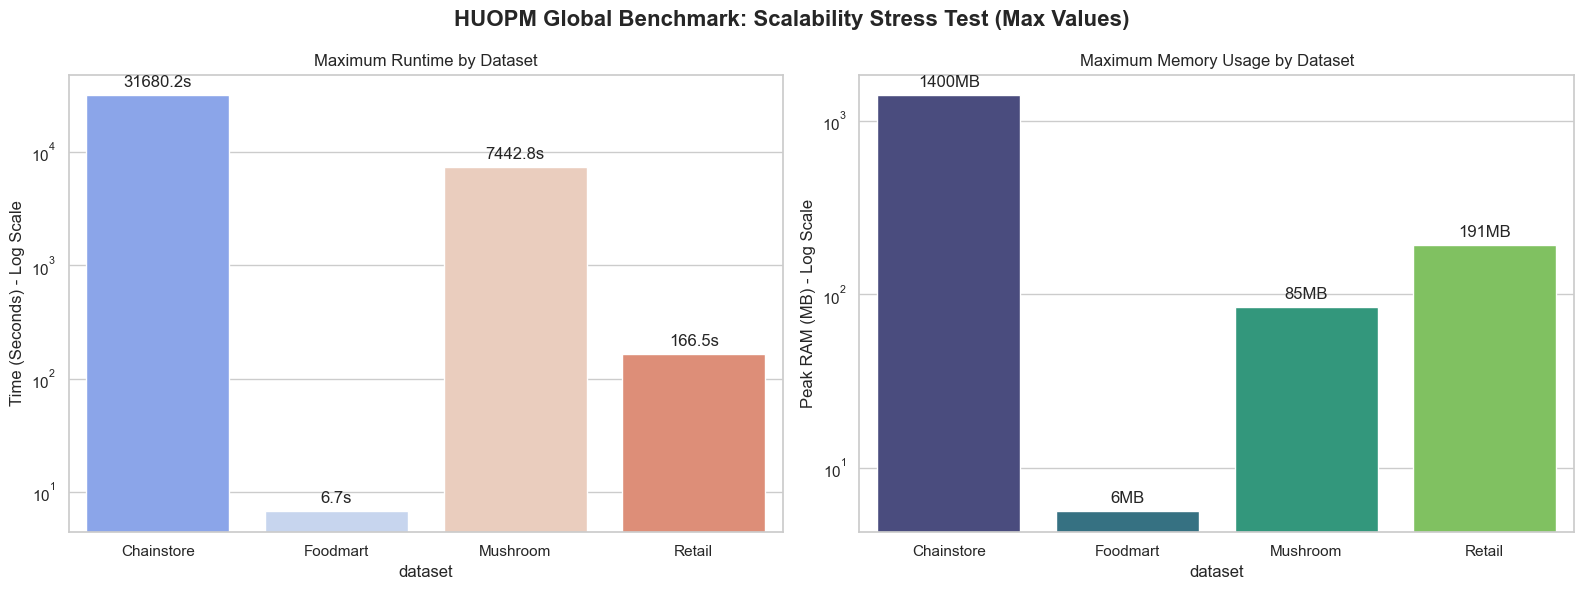

Saved to huopm_plots/Global_Comparison.png

All plots generated in folder: 'huopm_plots'


In [12]:
# Configuration
RESULTS_DIR = "huopm_results"  
PLOTS_DIR = "huopm_plots"      
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set global style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

def load_all_summaries(root_dir):
    """
    Recursively finds all *_summary.csv files and combines them.
    """
    all_files = glob.glob(os.path.join(root_dir, "**", "*_summary.csv"), recursive=True)
    
    if not all_files:
        print("No summary CSV files found!")
        return pd.DataFrame()
    
    df_list = []
    for filename in all_files:
        print(f"Loading: {filename}")
        try:
            df = pd.read_csv(filename)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    return pd.DataFrame()

def plot_dataset_details(df, dataset_name):
    """
    Generates detailed line charts for a single dataset:
    1. Runtime vs Alpha
    2. Memory vs Alpha
    3. Patterns vs Alpha
    """
    print(f"Plotting details for: {dataset_name}")
    
    # Filter data for this dataset
    data = df[df['dataset'] == dataset_name].copy()
    
    # Sort to make line plots look right
    data = data.sort_values(by='alpha', ascending=False)
    
    # Create a 1x3 subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Dataset Analysis: {dataset_name}', fontsize=16, weight='bold')
    
    # Plot 1: Runtime
    sns.lineplot(ax=axes[0], data=data, x='alpha', y='runtime_sec', hue='beta', 
                 palette='viridis', marker='o', style='beta')
    axes[0].set_title('Runtime vs. Support (Alpha)')
    axes[0].set_ylabel('Time (Seconds)')
    axes[0].set_xlabel('Minimum Support (Alpha)')
    axes[0].invert_xaxis() # Standard convention: Lower support (harder) on right
    
    # Plot 2: Memory
    sns.lineplot(ax=axes[1], data=data, x='alpha', y='peak_memory_mb', hue='beta', 
                 palette='magma', marker='s', style='beta')
    axes[1].set_title('Memory Usage vs. Support')
    axes[1].set_ylabel('Peak RAM (MB)')
    axes[1].set_xlabel('Minimum Support (Alpha)')
    axes[1].invert_xaxis()
    
    # Plot 3: Patterns Found
    sns.lineplot(ax=axes[2], data=data, x='alpha', y='patterns_found', hue='beta', 
                 palette='deep', marker='^', style='beta')
    axes[2].set_title('Pattern Count vs. Support')
    axes[2].set_ylabel('Number of HUOPs')
    axes[2].set_xlabel('Minimum Support (Alpha)')
    axes[2].set_yscale('log') # Log scale is usually needed for patterns
    axes[2].invert_xaxis()
    
    # Save
    save_path = os.path.join(PLOTS_DIR, f"{dataset_name}_analysis.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved to {save_path}")

def plot_global_comparison(df):
    """
    Plots a high-level bar chart comparing all datasets.
    Since Alphas differ, we compare the Maximum Runtime/Memory recorded per dataset.
    """
    print("Plotting global comparison...")
    
    # Aggregate to find MAX impact per dataset (Stress Test view)
    df_agg = df.groupby('dataset').agg({
        'runtime_sec': 'max',
        'peak_memory_mb': 'max',
        'patterns_found': 'max'
    }).reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('HUOPM Global Benchmark: Scalability Stress Test (Max Values)', fontsize=16, weight='bold')
    
    # Plot 1: Max Runtime Comparison
    # Removed 'legend=False' to prevent AttributeError on older seaborn versions
    sns.barplot(ax=axes[0], data=df_agg, x='dataset', y='runtime_sec', palette='coolwarm', hue='dataset', dodge=False)
    axes[0].set_title('Maximum Runtime by Dataset')
    axes[0].set_ylabel('Time (Seconds) - Log Scale')
    axes[0].set_yscale('log') # Crucial for Chainstore vs Foodmart
    
    # Manually remove legend if it exists (Compatible with all versions)
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()
    
    # Add labels on top
    for p in axes[0].patches:
        # Check if height is valid (not NaN or 0 for log scale safety)
        height = p.get_height()
        if height > 0:
            axes[0].annotate(f'{height:.1f}s', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha = 'center', va = 'center', xytext = (0, 9), 
                             textcoords = 'offset points')

    # Plot 2: Max Memory Comparison
    sns.barplot(ax=axes[1], data=df_agg, x='dataset', y='peak_memory_mb', palette='viridis', hue='dataset', dodge=False)
    axes[1].set_title('Maximum Memory Usage by Dataset')
    axes[1].set_ylabel('Peak RAM (MB) - Log Scale')
    axes[1].set_yscale('log')
    
    # Manually remove legend
    if axes[1].get_legend() is not None:
        axes[1].get_legend().remove()
    
    # Add labels on top
    for p in axes[1].patches:
        height = p.get_height()
        if height > 0:
            axes[1].annotate(f'{height:.0f}MB', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha = 'center', va = 'center', xytext = (0, 9), 
                             textcoords = 'offset points')

    save_path = os.path.join(PLOTS_DIR, "Global_Comparison.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Saved to {save_path}")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Load Data
    full_df = load_all_summaries(RESULTS_DIR)
    
    if not full_df.empty:
        print("\nData loaded successfully. Columns:", full_df.columns.tolist())
        
        # 2. Plot Individual Dataset Details
        unique_datasets = full_df['dataset'].unique()
        for ds in unique_datasets:
            plot_dataset_details(full_df, ds)
            
        # 3. Plot Global Comparison
        plot_global_comparison(full_df)
        
        print(f"\nAll plots generated in folder: '{PLOTS_DIR}'")
    else:
        print("No data found to plot.")